# Collect Data

In [ ]:
from coletor import collect_data
import os
from time import sleep
collect_data()
sleep(1)
os.system(r'''taskkill /IM terminal64.exe''')

# Get previsions

In [ ]:
import os
os.system(r'''matlab.exe -nosplash -nodesktop -batch "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end; quit"''')
# os.system(r'''matlab.exe -r "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end;"''')

# Run Backtests

In [12]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


alavancagem = 2

def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain, alavancagem = teste
    trader = Trader(stop, gain)
    trader.leverage = alavancagem
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain
    }

iterable = []

for index, m15_file in enumerate(m15_files):
    # if m15_file.split("/data\\")[1].split("_")[0] != "WDO":
    #     continue
    df_d1     = pd.read_csv(d1_files[index])
    df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

    df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
    df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

    df_m15 = pd.read_csv(m15_file)
    df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
    iterable.append((df_m15, df_d1, m15_file, 0.25, 0.85, alavancagem))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)


# Distribuição resultados

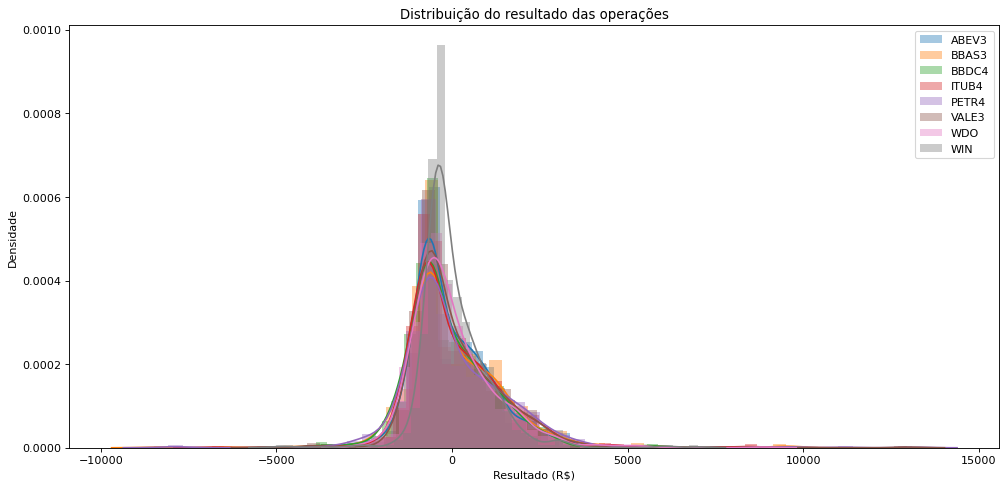

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,7), dpi= 80)

for item in dfs_orders_summary:
    sns.distplot(item["df_orders_summary"]["result"], label=item["stock_code"])
plt.legend()
plt.title("Distribuição do resultado das operações")
plt.xlabel("Resultado (R$)")
plt.ylabel("Densidade")
plt.savefig(f'../results/distribuição_resultados.png')

# Resultado linhas

In [14]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_width = "1184"
pio.kaleido.scope.default_height = "450"
fig = go.Figure()
for item in dfs_orders_summary:
    fig.add_trace(go.Scatter(x=item["df_orders_summary"]["time"], y=item["df_orders_summary"]["cum_result"],
                        mode='lines',
                        name=item["stock_code"]))
# fig.update_layout(yaxis_range=[0,150000000000e3])
fig.show()
fig.write_image("../results/resultados.png")



# Cálculo Métricas

In [15]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.35, 0.8)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "annualized_returns": annualized
    })

df_metrics_results = pd.DataFrame(metrics_results)
teste = df_metrics_results.agg(['mean', 'std']).reset_index()
teste = teste.rename(columns={'index': 'stock_code'})
df_metrics_results = pd.concat([df_metrics_results,teste]).reset_index(drop=True)

In [ ]:
df_metrics_results.to_latex(f"../results/capital_inicial_{alavancagem}x_alavancado.tex", index=False)
display(df_metrics_results)

# Contorno do stop gain

In [ ]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np
m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain = teste
    trader = Trader(stop, gain)
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain
    }

iterable = []
stops = [
    (0.45, 0.5),
    (0.15, 0.75),
    (0.2, 0.9),
    (0.2, 0.75),
    (0.15, 0.9)
]
for stop in np.arange(0.1, 0.6, 0.05):
    for gain in np.arange(0.5, 1.05, 0.05):
# for stop, gain in stops:
        for index, m15_file in enumerate(m15_files):
            # if m15_file.split("/data\\")[1].split("_")[0] == "MGLU3":
            #     continue
            if m15_file.split("/data\\")[1].split("_")[0] not in ["VALE3", "PETR4", "WIN", "WDO"]:
                continue
            df_d1     = pd.read_csv(d1_files[index])
            df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

            df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
            df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

            df_m15 = pd.read_csv(m15_file)
            df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
            iterable.append((df_m15, df_d1, m15_file, stop, gain))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)



In [ ]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.20, 0.60)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "gain": item["gain"],
        "stop": item["stop"],
        "annualized_returns": annualized
    })

pd.DataFrame(metrics_results).sort_values(by=['stock_code', 'annualized_returns'], ascending=False)
df_metrics_results = pd.DataFrame(metrics_results)

In [ ]:
df_metrics_results.to_csv("../results/stop_take_metrics_results.csv")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df_metrics_results = pd.read_csv("../results/stop_take_metrics_results.csv")

for stock in ["VALE3", "PETR4", "WIN", "WDO"]:
    
    fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
    fig.tight_layout(pad=3.0)
    fig.suptitle(f"Otimização Stop-Loss/Take-Profit ({stock})")

    df_metrics_results["gain"] = round(df_metrics_results["gain"], 2)
    df_metrics_results["stop"] = round(df_metrics_results["stop"], 2)

    df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == stock][["stop", "gain", "annualized_returns"]]
    df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')
    ax = sns.heatmap(df_heatmap, ax = axes[0])
    ax.title.set_text('Retorno Anualizado')
    ax.set_ylabel('Stop-Loss')
    ax.set_xlabel('Take-Profit')

    ax.tick_params(labelrotation=45)


    df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == stock][["stop", "gain", "maximum_drawdown_percentage"]]
    df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='maximum_drawdown_percentage')
    ax = sns.heatmap(df_heatmap, ax = axes[1])
    ax.title.set_text('Drawdown Máximo')
    ax.tick_params(labelrotation=45)
    ax.set_ylabel('Stop-Loss')
    ax.set_xlabel('Take-Profit')

    # plt.savefig(f'../results/stop_loss_take_profit_{stock}.png')

In [ ]:
df_metrics_results_group = df_metrics_results[["gain", "stop", "maximum_drawdown_percentage", "annualized_returns"]].groupby(["gain", "stop"]).mean()

fig, axes = plt.subplots(1, 2, figsize=(12,5), dpi=150)
fig.tight_layout(pad=3.0)
fig.suptitle(f"Média resultados otimização Stop-Loss/Take-Profit")

df_metrics_results["gain"] = round(df_metrics_results["gain"], 2)
df_metrics_results["stop"] = round(df_metrics_results["stop"], 2)

df_heatmap = df_metrics_results_group.reset_index()
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')
ax = sns.heatmap(df_heatmap, ax = axes[0], annot=True)
ax.title.set_text('Retorno Anualizado (%)')
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')

ax.tick_params(labelrotation=45)


df_heatmap = df_metrics_results_group.reset_index()
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='maximum_drawdown_percentage')
ax = sns.heatmap(df_heatmap, ax = axes[1], annot=True)
ax.title.set_text('Drawdown Máximo (%)')
ax.tick_params(labelrotation=45)
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')
plt.savefig(f'../results/stop_loss_take_profit_mean.png')

In [ ]:
df_metrics_results_group.reset_index()

# Analyse results

In [ ]:
df_metrics_results[["gain", "stop", "maximum_drawdown_percentage", "annualized_returns"]].reset_index()

In [ ]:
df_orders_exit_order["cum_result"] = df_orders_exit_order["result"].cumsum()

fig = px.line(df_orders_exit_order, x="time", y=["min_ann", "max_ann", "close", "cum_result"])
fig.show()

In [ ]:
from IPython.core.display import display, HTML

for item in dfs_orders_summary:
    if (item["stock_code"] != "WDO"):
        continue
    df_orders_summary = item["df_orders_summary"]
    display(HTML(df_orders_summary.to_html()))


# Benchs

In [6]:
from benchmark import Benchmark
benchmark = Benchmark()
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*D1.csv")
print(d1_files)

prevision_results = []

def erro (ys ,ydv):
    erro2 = 100 * abs((ydv-ys)/ydv);
    return sum(erro2) / len(ydv)

def calc_acerto (ys ,ydv):
    acerto = 0
    for k in range(2, len(ydv)):
        aux=(ys[k]-ys[k-1])*(ydv[k]-ydv[k-1]);
        if aux>=0:
            acerto=acerto+1;
    return acerto*100/len(ydv)

for index, d1_file in enumerate(d1_files):
    df_d1 = pd.read_csv(d1_files[index])
    # mma = benchmark.mma(df_d1, 5)
    for bench, func in [
            ("MMS-5", benchmark.sma_5),
            ("MMS-10", benchmark.sma_10),
            ("MMS-20", benchmark.sma_20),
            ("one-day-lag", benchmark.one_day_lag)
        ]:
        
        df_prevision_data = func(df_d1)

        mape_low = erro(df_prevision_data["low"], df_prevision_data["min_ann"])
        mape_high = erro(df_prevision_data["high"], df_prevision_data["max_ann"])

        acerto_low = calc_acerto(df_prevision_data["low"], df_prevision_data["min_ann"])
        acerto_high = calc_acerto(df_prevision_data["high"], df_prevision_data["max_ann"])

        stock = d1_file.split("\\")[1].split(".")[0]
        df_prevision_data[["time", "min_ann", "max_ann", "real_volume"]].to_csv(f'../{bench}/{stock}.csv', header=False, index=False)

        prevision_results.append({
            "benchmark": bench,
            "epm_min": mape_low,
            "epm_max": mape_high,
            "acerto_min": acerto_low,
            "acerto_max": acerto_high,
        })

benchmark_df = pd.DataFrame(prevision_results).groupby(["benchmark"]).agg(['mean', 'std']).reset_index()
benchmark_df.to_latex("../results/benchmark.tex", index=False, float_format="{:0.2f}".format)




['C:/Users/gubar/Documents/UFMG/TCC/data\\ABEV3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\BBAS3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\BBDC4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\ITUB4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\PETR4_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\VALE3_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\WDO_D1.csv', 'C:/Users/gubar/Documents/UFMG/TCC/data\\WIN_D1.csv']


In [1]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np

m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")

d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/one-day-lag/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-5/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-10/*D1.csv")
d1_files = d1_files + glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/MMS-20/*D1.csv")

alavancagem = 2

def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain, alavancagem, d1_file = teste
    trader = Trader(stop, gain)
    trader.leverage = alavancagem
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "benchmark": d1_file.split("/")[6].split("\\")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain,

    }

iterable = []

for index, m15_file in enumerate(m15_files):

    stock_code = m15_file.split("/data\\")[1].split("_")[0]
    stock_files = filter(lambda d1_file: stock_code in d1_file , d1_files) 

    for j, d1_file in enumerate(stock_files):
        # if m15_file.split("/data\\")[1].split("_")[0] != "WDO":
        #     continue
        df_d1     = pd.read_csv(d1_file)
        df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

        df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
        df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

        df_m15 = pd.read_csv(m15_file)
        df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
        iterable.append((df_m15, df_d1, m15_file, 0.25, 0.85, alavancagem, d1_file))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)


In [11]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.35, 0.8)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "annualized_returns": annualized,
        "benchmark": item["benchmark"]
    })

df_metrics_results = pd.DataFrame(metrics_results)
# display(df_metrics_results)
teste = df_metrics_results.groupby(["benchmark"]).agg(['mean', 'std']).reset_index()
teste = teste.rename(columns={'index': 'stock_code'})

df_metrics_results = pd.concat([df_metrics_results,teste]).reset_index(drop=True)
teste

teste.to_latex(f"../results/negociador_benchmark.tex", index=False, float_format="{:0.2f}".format)